In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import re

In [2]:
path = '/home/isaackhor/code/lsvd-rbd/experiments/results/2024-01-09T22:10:51.lsvd-240.rssd2.txt'

with open(path, 'r') as f:
    content = f.readlines()

In [6]:
fio_runs_linenums = [ln for ln,l in enumerate(content) if l.startswith('===Fio: workload=') and not 'iops_limit' in l]
fio_runs = [content[ln:ln+34] for ln in fio_runs_linenums]
print(len(fio_runs))

fio_runs_iops_ln = [ln for ln,l in enumerate(content) if l.startswith('===Fio: workload') and 'iops_limit' in l]
fio_runs_iops = [content[ln:ln+34] for ln in fio_runs_iops_ln]
print(len(fio_runs_iops))

64
40


In [15]:
# Example output: 
# ===Fio: workload=randread, time=30, iodepth=128, bs=4ki, iops_limit=80000===

# j1: (g=0): rw=randread, bs=(R) 4096B-4096B, (W) 4096B-4096B, (T) 4096B-4096B, ioengine=io_uring, iodepth=128
# fio-3.28
# Starting 1 process

# j1: (groupid=0, jobs=1): err= 0: pid=718801: Tue Jan  9 22:34:43 2024
#   read: IOPS=68.4k, BW=267MiB/s (280MB/s)(8015MiB/30002msec)
#     slat (usec): min=4, max=7305, avg=12.24, stdev=27.20
#     clat (usec): min=160, max=9364, avg=1857.23, stdev=275.31
#      lat (usec): min=172, max=9372, avg=1869.72, stdev=275.76
#     clat percentiles (usec):
#      |  1.00th=[ 1090],  5.00th=[ 1467], 10.00th=[ 1582], 20.00th=[ 1680],
#      | 30.00th=[ 1745], 40.00th=[ 1795], 50.00th=[ 1860], 60.00th=[ 1909],
#      | 70.00th=[ 1958], 80.00th=[ 2024], 90.00th=[ 2147], 95.00th=[ 2245],
#      | 99.00th=[ 2737], 99.50th=[ 3064], 99.90th=[ 3228], 99.95th=[ 3326],
#      | 99.99th=[ 4146]
#    bw (  KiB/s): min=241832, max=303440, per=100.00%, avg=273738.31, stdev=16823.30, samples=59
#    iops        : min=60458, max=75860, avg=68434.61, stdev=4205.87, samples=59
#   lat (usec)   : 250=0.01%, 500=0.01%, 750=0.01%, 1000=0.41%
#   lat (msec)   : 2=75.83%, 4=23.74%, 10=0.01%
#   cpu          : usr=19.12%, sys=56.28%, ctx=85160, majf=0, minf=138
#   IO depths    : 1=0.1%, 2=0.1%, 4=0.1%, 8=0.1%, 16=0.1%, 32=0.1%, >=64=100.0%
#      submit    : 0=0.0%, 4=100.0%, 8=0.0%, 16=0.0%, 32=0.0%, 64=0.0%, >=64=0.0%
#      complete  : 0=0.0%, 4=100.0%, 8=0.0%, 16=0.0%, 32=0.0%, 64=0.0%, >=64=0.1%
#      issued rwts: total=2051913,0,0,0 short=0,0,0,0 dropped=0,0,0,0
#      latency   : target=0, window=0, percentile=100.00%, depth=128

# Run status group 0 (all jobs):
#    READ: bw=267MiB/s (280MB/s), 267MiB/s-267MiB/s (280MB/s-280MB/s), io=8015MiB (8405MB), run=30002-30002msec

# Disk stats (read/write):
#   nvme1n1: ios=0/0, merge=0/0, ticks=0/0, in_queue=0, util=0.00%

# RESULT: Fio (iodepth=128; bs=4ki, iops_limit=80000) randread:  read: IOPS=68.4k, BW=267MiB/s (280MB/s)(8015MiB/30002msec)

def extract_iolim_fio(fio_run: str):
	fio_info = dict()

	regex = 'workload=(.*?), time=(.*?), iodepth=(.*?), bs=(.*?), iops_limit=(.*?)==='
	workload, _, iodepth, bs, iops_limit = re.search(regex, fio_run[0]).groups()

	fio_info['workload'] = workload
	fio_info['iodepth'] = iodepth
	fio_info['bs'] = int(bs[:-2])
	fio_info['iops_limit'] = int(iops_limit)

	fio_info['lat1'] = re.search('1.00th=\[ (.*?)\]', fio_run[12]).groups()[0]
	fio_info['lat50'] = re.search('50.00th=\[ (.*?)\]', fio_run[13]).groups()[0]
	fio_info['lat99'] = re.search('99.00th=\[ (.*?)\]', fio_run[15]).groups()[0]

	fio_info['bw'] = re.search('BW=(.*)MiB/s', fio_run[7]).groups()[0]
	x = re.search('IOPS=(.*),', fio_run[7]).groups()[0]
	fio_info['iops'] = int(1000*float(x.replace('k', ''))) if 'k' in x else int(x)
	return fio_info

extract_iolim_fio(fio_runs_iops[0])

{'workload': 'randread',
 'iodepth': '128',
 'bs': 4,
 'iops_limit': 10000,
 'lat1': ' 102',
 'lat50': ' 133',
 'lat99': ' 265',
 'bw': '39.1',
 'iops': 9999}

In [18]:
iops_runs_ex = [extract_iolim_fio(fio_run) for fio_run in fio_runs_iops]
randread_runs = [r for r in iops_runs_ex if r['workload'] == 'randread']
randread_runs = sorted(randread_runs, key=lambda x: x['iops'])
randread_runs

[{'workload': 'randread',
  'iodepth': '128',
  'bs': 4,
  'iops_limit': 10000,
  'lat1': ' 102',
  'lat50': ' 133',
  'lat99': ' 265',
  'bw': '39.1',
  'iops': 9999},
 {'workload': 'randread',
  'iodepth': '128',
  'bs': 4,
  'iops_limit': 20000,
  'lat1': ' 108',
  'lat50': ' 167',
  'lat99': ' 314',
  'bw': '78.1',
  'iops': 20000},
 {'workload': 'randread',
  'iodepth': '128',
  'bs': 4,
  'iops_limit': 30000,
  'lat1': ' 131',
  'lat50': ' 233',
  'lat99': ' 412',
  'bw': '117',
  'iops': 30000},
 {'workload': 'randread',
  'iodepth': '128',
  'bs': 4,
  'iops_limit': 40000,
  'lat1': ' 155',
  'lat50': ' 293',
  'lat99': '1483',
  'bw': '156',
  'iops': 40000},
 {'workload': 'randread',
  'iodepth': '128',
  'bs': 4,
  'iops_limit': 50000,
  'lat1': ' 186',
  'lat50': ' 469',
  'lat99': '3195',
  'bw': '195',
  'iops': 50000},
 {'workload': 'randread',
  'iodepth': '128',
  'bs': 4,
  'iops_limit': 60000,
  'lat1': ' 322',
  'lat50': '1074',
  'lat99': '2900',
  'bw': '234',
  '

In [20]:
iops = [r['iops'] for r in randread_runs]

lat1s = [int(r['lat1']) for r in randread_runs]
lat50s = [int(r['lat50']) for r in randread_runs]
lat99s = [int(r['lat99']) for r in randread_runs]


[9999, 20000, 30000, 40000, 50000, 60000, 64200, 67300, 68400, 71400]
[102, 108, 131, 155, 186, 322, 1303, 1037, 1090, 1090]
[133, 167, 233, 293, 469, 1074, 1975, 1860, 1860, 1778]
[265, 314, 412, 1483, 3195, 2900, 2769, 2802, 2737, 2507]


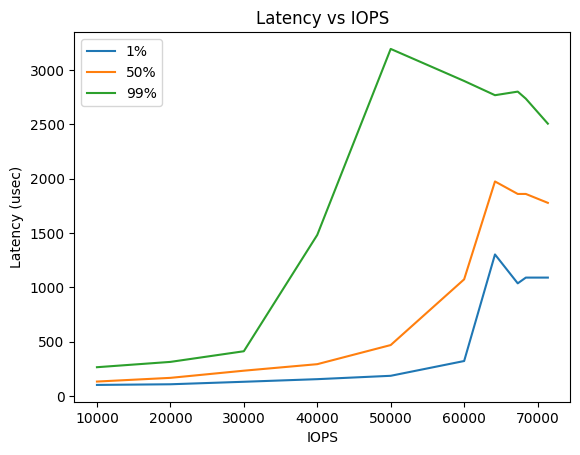

In [23]:
print(iops)
print(lat1s)
print(lat50s)
print(lat99s)

plt.figure()
plt.xlabel('IOPS')
plt.ylabel('Latency (usec)')
plt.title('Latency vs IOPS')
plt.plot(iops, lat1s, label='1%')
plt.plot(iops, lat50s, label='50%')
plt.plot(iops, lat99s, label='99%')
plt.legend()
plt.show()